# Protocol definition

In [1]:
# %load STMprotocol.py
import serial
import struct
import datetime
import time

class STMprotocol:
    def __init__(self, serial_port):
        self.ser = serial.Serial(serial_port, 64000, timeout=0.2)
        self.pack_format = {
            0x01: "=BBBB",
            0x03: "=Bf",
            0x04: "=B",
            0x05: "=B",
            0x06: "=Bffff",
            0x07: "=B",
            0x08: "=fff",
            0x09: "=",
            0x0a: "=",
            0x0b: "=BH",
            0x0c: "=B",
            0x0d: "=B",
            0x0e: "=fff",
            0x0f: "=",            
            0xa0: "=fff",
            0xa1: "=fff",
            0xb0: "=B",
            0xb1: "=B",
            0xa2: "=ffffff",

        }

        self.unpack_format = {
            0x01: "=BBBB",
            0x03: "=BB",
            0x04: "=BB",
            0x05: "=BB",
            0x06: "=BB",
            0x07: "=ffff",
            0x08: "=BB",
            0x09: "=fff",
            0x0a: "=fff",
            0x0b: "=BB",
            0x0c: "=f",
            0x0d: "=BB",
            0x0e: "=BB",
            0x0f: "=fff",
            0xa0: "=Bfff",
            0xa1: "=BB",
            0xb0: "=BB",
            0xb1: "=BB",
            0xa2: "=BB",
        }

    def send_command(self, cmd, args):
        # Clear buffer
        print(self.ser.read(self.ser.in_waiting))
        
        parameters = bytearray(struct.pack(self.pack_format[cmd], *args))
        print(parameters)
        msg_len = len(parameters) + 5
        msg = bytearray([0xfa, 0xaf, msg_len, cmd]) + parameters
        crc = sum(msg) % 256
        msg += bytearray([crc])

        print("send ", repr(msg))
        self.ser.write(msg)

        start_time = datetime.datetime.now()
        time_threshold = datetime.timedelta(seconds=1)
        dt = start_time - start_time
        
        time.sleep(0.001)
        data = self.ser.read()[0]
        while (data != 0xfa) and (dt < time_threshold):
            data = self.ser.read()[0]

            current_time = datetime.datetime.now()
            dt = start_time - current_time

        adr = self.ser.read()[0]
        answer_len = self.ser.read()[0]
        answer = bytearray(self.ser.read(answer_len - 3))
        print("answer ", repr(bytearray([data, adr, answer_len]) + answer))

        args = struct.unpack(self.unpack_format[cmd], answer[1:-1])
        return args


# Function of animation of output data

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
class Output_ploter(object):
    def __init__(self):
        self.xdata = []
        self.ydata = []
    def time_plot(self, protocol, cmd, args, param, time_duration=10):
        def generate_data():
            while(1): 
                res = protocol.send_command(cmd, args)
                yield res

        fig, ax = plt.subplots()
        ln, = ax.plot([])
        start_time = time.time()
        def init():
            ax.set_xlim(0, time_duration)
            return ln, 

        def update(frame):
            self.xdata.append(time.time() - start_time)
            self.ydata.append(frame[param])
            ln.set_data(self.xdata, self.ydata)
            if time_duration < self.xdata[-1]:
                ax.set_xlim(self.xdata[-1] - time_duration, self.xdata[-1])
            ax.set_ylim(min(self.ydata), max(self.ydata))
            return ln, 
        ani = FuncAnimation(fig, update, frames=generate_data(),
                        init_func=init, blit=True, interval=25)
        return ani
    def xy_plot(self, protocol, cmd, args, params, time_duration=10):
        def generate_data():
            while(1): 
                res = protocol.send_command(cmd, args)
                yield res

        fig, ax = plt.subplots()
        ln, = ax.plot([])
        start_time = time.time()
        def init():
            ax.set_xlim(0, time_duration)
            return ln, 

        def update(frame):
            self.xdata.append(frame[params[0]])
            self.ydata.append(frame[params[1]])
            ln.set_data(self.xdata, self.ydata)
            ax.set_xlim(min(self.xdata), max(self.xdata))
            ax.set_ylim(min(self.ydata), max(self.ydata))
            return ln, 
        ani = FuncAnimation(fig, update, frames=generate_data(),
                        init_func=init, blit=True, interval=25)
        return ani
    def qxy_plot(self, protocol, cmd, args, params, time_duration=10):
        def generate_data():
            while(1): 
                res = protocol.send_command(cmd, args)
                yield res

        fig, ax = plt.subplots()
        ln, = ax.plot([])
        start_time = time.time()
        def init():
            ax.set_xlim(0, time_duration)
            return ln, 

        def update(frame):
            self.xdata.append(frame[params[0]])
            self.ydata.append(frame[params[1]])
            ln.set_data(self.xdata, self.ydata)
            ax.set_xlim(min(self.xdata), max(self.xdata))
            ax.set_ylim(min(self.ydata), max(self.ydata))
            return ln, 
        ani = FuncAnimation(fig, update, frames=generate_data(),
                        init_func=init, blit=True, interval=25)
        return ani

# Work with STM

## Start protocol

In [139]:
protocol = STMprotocol("COM5")

In [138]:
protocol.ser.close()

## Test echo

In [140]:
# Echo
protocol.send_command(0x01, [ord(c) for c in 'ECHO'])

b''
bytearray(b'ECHO')
send  bytearray(b'\xfa\xaf\t\x01ECHO\xd2')
answer  bytearray(b'\xfa\xfa\t\x01ECHO\x1d')


(69, 67, 72, 79)

## On-line plotting of output data

## Time plotter

<IPython.core.display.Javascript object>


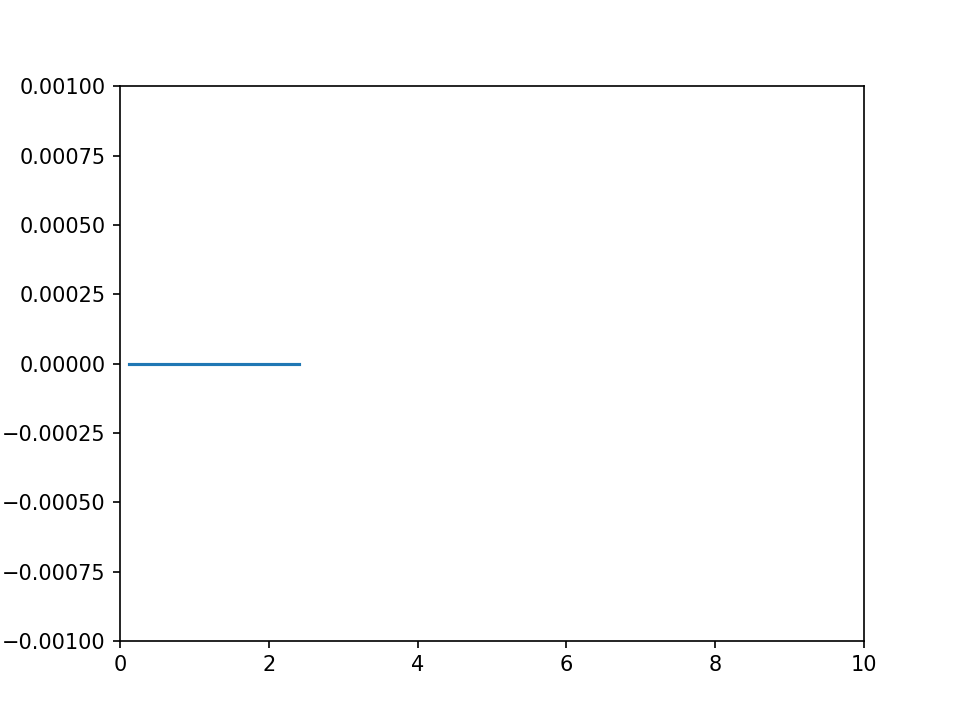

In [5]:
ploter = Output_ploter()
ani = ploter.time_plot(protocol, 0x07, [4], 3, 10)

## XY plotter

In [ ]:
ploter = Output_ploter()
ani = ploter.xy_plot(protocol, 0x0F, [], [0,1], 10)

In [ ]:
print(ploter.xdata)

## Debug low level commands

In [6]:
# Set duty cycle of particular PWM channel
channel = 1
dutyCycle = 0.1
protocol.send_command(0x03, [channel, dutyCycle])

b''
bytearray(b'\x01\xcd\xcc\xcc=')
send  bytearray(b'\xfa\xaf\n\x03\x01\xcd\xcc\xcc=Y')
answer  bytearray(b'\xfa\xfa\x07\x03OK\x98')


(79, 75)

In [ ]:
protocol.send_command(0x0F, [])

In [ ]:
# Set direction bit for particular motor
channel = 1
protocol.send_command(0x04, [channel])

In [ ]:
# Reset direction bit for particular motor
channel = 1
protocol.send_command(0x05, [channel]);

In [ ]:
# Set speed of all motors in rad/s

protocol.send_command(0x06, [4, 0, 0, 0, 12])

In [ ]:
# Read speed of all wheels in rad/s
numberOfmotors = 4
protocol.send_command(0x07, [numberOfmotors])

## Set and get Robot's speed in its own coordinate system

In [ ]:
# Set robot speed in its own coordinate system
Vx = 0.1
Vy = 0.1
Wz = 0.7
protocol.send_command(0x08, [Vx, Vy, Wz])

In [ ]:
# Set robot speed to 0 in its own coordinate system
Vx = 0.0
Vy = 0.0
Wz = 0.0

protocol.send_command(0x08, [Vx, Vy, Wz])

In [ ]:
# Read robot speed in its own coordinate system
protocol.send_command(0x09, [])

## Read Robot's coordinates' increments (robot coordinate system)

In [5]:
# Read robot coord in its own coordinate system
protocol.send_command(0x0a, [])

b''
bytearray(b'')
send  bytearray(b'\xfa\xaf\x05\n\xb8')
answer  bytearray(b'\xfa\xfa\x11\n\xd8\xfa\xa2\xbd\xc1\x7f\x7f\xb9\x8f\x8c\x1b=+')


(-0.07958000898361206, -0.0002436628710711375, 0.037975843995809555)

## Set Command for manipulator

In [291]:
# Take cube
protocol.send_command(0xB0, [2])
protocol.send_command(0xB0, [0])

b''
bytearray(b'\x02')
send  bytearray(b'\xfa\xaf\x06\xb0\x02a')
answer  bytearray(b'\xfa\xfa\x07\xb0OKE')
b''
bytearray(b'\x00')
send  bytearray(b'\xfa\xaf\x06\xb0\x00_')
answer  bytearray(b'\xfa\xfa\x07\xb0OKE')


(79, 75)

In [201]:
# Unload tower
protocol.send_command(0xB1, [2])
#protocol.send_command(0xB1, [0])

b''
bytearray(b'\x02')
send  bytearray(b'\xfa\xaf\x06\xb1\x02b')
answer  bytearray(b'\xfa\xfa\x07\xb1OKF')


(79, 75)

## Set and get Robot's global coordinates 

In [ ]:
# Set robot global coord
x = 0
y = 0
alpha = 0
protocol.send_command(0x0E, [x, y, alpha])

In [ ]:
# Get robot global coord
protocol.send_command(0x0F, [])

## Set and get angle of particular servo motor (dynamixel)

In [80]:
# Move servo of particular id (first parameter), to specified angle (second parameter) 
servoId = 2
angle = 265
protocol.send_command(0x0b, [servoId, angle])

b''
bytearray(b'\x02\t\x01')
send  bytearray(b'\xfa\xaf\x08\x0b\x02\t\x01\xc8')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [78]:
# Get angle of particular servo
servoId = 2
protocol.send_command(0x0c, [servoId])

b''
bytearray(b'\x02')
send  bytearray(b'\xfa\xaf\x06\x0c\x02\xbd')
answer  bytearray(b'\xfa\xfa\t\x0c\xc2\x06\xfbB\x0e')


(125.51319885253906,)

## Odometry movement

In [175]:
deltaX = 0.0
deltaY = 0.0
deltaW = 0.017

speedX = 1.0
speedY = 1.0
speedW = 3.0

protocol.send_command( 0xa2, [deltaX, deltaY, deltaW, speedX, speedY, speedW])

b''
bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x96C\x8b<\x00\x00\x80?\x00\x00\x80?\x00\x00@@')
send  bytearray(b'\xfa\xaf\x1d\xa2\x00\x00\x00\x00\x00\x00\x00\x00\x96C\x8b<\x00\x00\x80?\x00\x00\x80?\x00\x00@@\x06')
answer  bytearray(b'\xfa\xfa\x07\xa2OK7')


(79, 75)

In [164]:
radius = 0.06

deltaY = 0.0
deltaW = -3.14/2
deltaX = deltaW * radius

speedW = 1.5
speedX = speedW * radius
speedY = 0.0

protocol.send_command( 0xa2, [deltaX, deltaY, deltaW, speedX, speedY, speedW])

b''
bytearray(b'\xee\xeb\xc0\xbd\x00\x00\x00\x00\xc3\xf5\xc8\xbf\xecQ\xb8=\x00\x00\x00\x00\x00\x00\xc0?')
send  bytearray(b'\xfa\xaf\x1d\xa2\xee\xeb\xc0\xbd\x00\x00\x00\x00\xc3\xf5\xc8\xbf\xecQ\xb8=\x00\x00\x00\x00\x00\x00\xc0?.')
answer  bytearray(b'\xfa\xfa\x07\xa2OK7')


(79, 75)

## Turn on and off forward kinematics calculations

In [ ]:
# Turn on/off forward kinematics calculations
status = 1
protocol.send_command(0x0D, [status])

## Get robot's status

In [ ]:
# Get status
protocol.send_command(0xa0, [1, 1, 1])

## Demo with manipulator

In [ ]:
# Parameters for right manipulator
rightSliderId = 1
rightGripperId = 16

rightSliderUpPos = 45
rightSliderBotPos = 300
rightGripperOpened = 40
rightGripperClosed = 150

In [ ]:
# Open and lower manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperOpened])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderBotPos])

In [ ]:
# Close and lift manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperClosed])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderUpPos])

In [ ]:
# Open and lower manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperOpened])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderBotPos])

In [ ]:
# Close and lift manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperClosed])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderUpPos])

In [ ]:
# Open and lower manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperOpened])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderBotPos])

In [ ]:
# Close and lift manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperClosed])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderUpPos])

In [ ]:
# Lower and open
protocol.send_command(0x0b, [rightSliderId, rightSliderBotPos])
time.sleep(1)
protocol.send_command(0x0b, [rightGripperId, rightGripperOpened])

## Demo with Robot's motion

In [ ]:

#Vx = 0.0
#Vy = 0.0
#Wz = 3.1415926/2
#protocol.send_command(0x08, [Vx, Vy, Wz])

#time.sleep(4)

Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(0.3)

In [ ]:
Vx = 0.0
Vy = 0.1
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(4)

Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(0.3)

In [ ]:
Vx = 0.1 / 2 ** 0.5
Vy = -0.1 / 2 ** 0.5
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(4)

Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(0.3)


In [ ]:
Vx = -0.1
Vy = -0.1
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(4)

Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])